In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [3]:
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [4]:
# Identify categorical and numerical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()[:-1]  # Exclude the target variable
print('Categorical features:', categorical_features)
print('Numerical features:', numerical_features)

Categorical features: ['lead_source', 'industry', 'employment_status', 'location']
Numerical features: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [5]:
# Fill missing values
df[categorical_features] = df[categorical_features].fillna('NA')
df[numerical_features] = df[numerical_features].fillna(0)

In [6]:
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NA,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NA,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [7]:
# Q1. What is the most frequent observation (mode) for the column industry?
df['industry'].mode()[0]

'retail'

In [8]:
correlation_matrix = df[numerical_features].corr()
correlation_matrix

,number_of_courses_viewed,annual_income,interaction_count,lead_score
number_of_courses_viewed,1.000000,0.009770,-0.023565,-0.004879
annual_income,0.009770,1.000000,0.027036,0.015610
interaction_count,-0.023565,0.027036,1.000000,0.009888
lead_score,-0.004879,0.015610,0.009888,1.000000


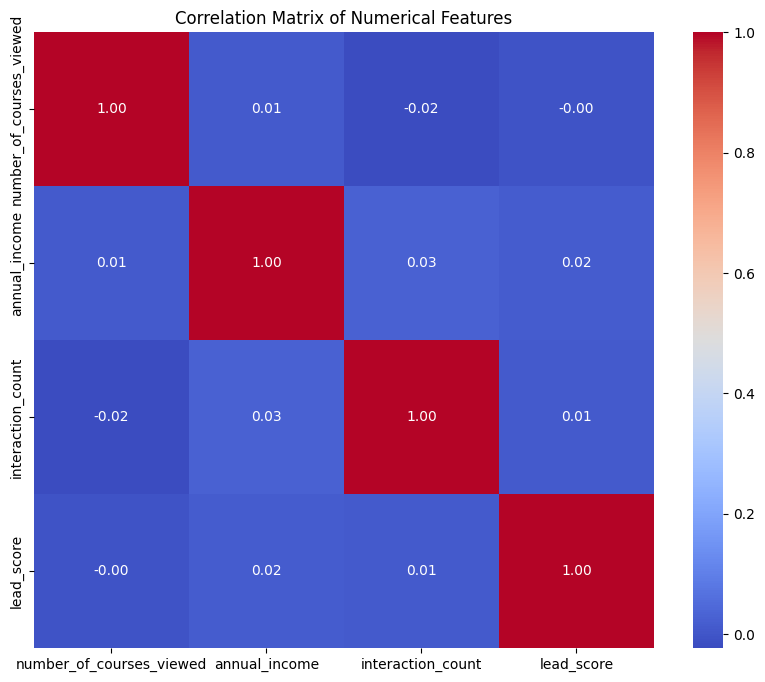

In [9]:
# visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [10]:
# Q2. What are the two features that have the biggest correlation?
# Answer: annual_income and interaction_count

In [11]:
# Split the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [12]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
# Separate target variable
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values
# Remove target variable from feature set
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [13]:
mi = pd.Series(dtype=float)
for c in categorical_features:
    mi[c] = mutual_info_score(df_train[c], y_train)
mi = mi.sort_values(ascending=False)
mi

lead_source          0.035396
employment_status    0.012938
industry             0.011575
location             0.004464
dtype: float64

In [14]:
# One-hot encoding
train_dicts = df_train[categorical_features + numerical_features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.transform(val_dicts)
test_dicts = df_test[categorical_features + numerical_features].to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [19]:
# train the model
model_baseline = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model_baseline.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [20]:
y_val_pred_baseline = model_baseline.predict(X_val)
accuracy_baseline = accuracy_score(y_val, y_val_pred_baseline)
print(f'Accuracy: {accuracy_baseline:.2f}')

Accuracy: 0.70


In [21]:
# Q4 What is the accuracy of the model on validation?
# Answer: 0.74

In [ ]:
# A function to evaluate the model without a specific feature
def evaluate_without_feature(feature_to_exclude):
    # Get the feature names from the DictVectorizer
    feature_names = dv.get_feature_names_out()
    
    # Find indices of features to keep (all except the ones to exclude)
    exclude_indices = [i for i, feat in enumerate(feature_names) if feature_to_exclude in feat]
    keep_indices = [i for i in range(len(feature_names)) if i not in exclude_indices]
    
    # Create new datasets without the feature
    X_train_reduced = X_train[:, keep_indices]
    X_val_reduced = X_val[:, keep_indices]
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train_reduced, y_train)
    
    # Evaluate on validation set
    y_val_pred = model.predict(X_val_reduced)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    return accuracy

In [ ]:
# Q5 Which of following feature has the smallest difference?
# Evaluate the model without each feature
features_to_test = ['industry', 'employment_status', 'lead_score']
results = {}

for feature in features_to_test:
    accuracy_without_feature = evaluate_without_feature(feature)
    difference = accuracy_baseline - accuracy_without_feature
    results[feature] = {
        'accuracy': accuracy_without_feature,
        'difference': difference
    }
    print(f"Without {feature}: Accuracy = {accuracy_without_feature:.6f}, Difference = {difference:.6f}")

# Find the feature with the smallest difference
min_feature = min(results, key=lambda x: abs(results[x]['difference']))
print(f"\nFeature with smallest impact: {min_feature}, Difference: {results[min_feature]['difference']:.6f}")

Without industry: Accuracy = 0.699659, Difference = 0.000000
Without employment_status: Accuracy = 0.696246, Difference = 0.003413
Without lead_score: Accuracy = 0.706485, Difference = -0.006826

Feature with smallest impact: industry, Difference: 0.000000


In [25]:
# Q6: Train regularized logistic regression with different C values

# C values to test
c_values = [0.01, 0.1, 1, 10, 100]

# Dictionary to store results
c_results = {}

# Train and evaluate models for each C value
for c in c_values:
    # Train model with current C value
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    # Store result (rounded to 3 decimal places)
    c_results[c] = round(accuracy, 3)
    
    print(f"C = {c}, Validation Accuracy = {c_results[c]}")

# Find the best C value (if multiple have the same accuracy, take the smallest)
best_accuracy = max(c_results.values())
best_c_values = [c for c, acc in c_results.items() if acc == best_accuracy]
best_c = min(best_c_values)

print(f"\nBest C value: {best_c} with validation accuracy: {c_results[best_c]}")

C = 0.01, Validation Accuracy = 0.7
C = 0.1, Validation Accuracy = 0.7
C = 1, Validation Accuracy = 0.7
C = 10, Validation Accuracy = 0.7
C = 100, Validation Accuracy = 0.7

Best C value: 0.01 with validation accuracy: 0.7
